<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/FINANCE/RetirementBootstrapMonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Retirement Simulator

A **Monte Carlo simulation** is used to model the potential outcomes of a retirement portfolio, starting with an initial withdrawal rate and running calculations on a **monthly basis**. The simulation uses historical data from **Robert Shiller**, including the **S&P 500 index**, dividends, **Consumer Price Index (CPI)**, and **10-year Treasury bond interest rates (GS10)** between the years of 1871 and 2023. The portfolio consists of two asset classes: the S&P 500 to represent equities and an **intermediate-term bond fund based on 7-year-duration** approximations using GS10 data for fixed income. A target allocation can be specified (e.g., **70% stocks, 30% bonds**), and the portfolio is periodically **rebalanced** to maintain this allocation. To maintain realism, all calculations are performed in an **inflation-adjusted** manner using the CPI to account for changes in purchasing power over time. The simulation applies a **block bootstrap** approach, where blocks of consecutive months are resampled from historical data to preserve patterns of autocorrelation, providing a realistic range of outcomes that consider the historical relationship between stocks and bonds. **Transaction costs** are included during the rebalancing process, but it is assumed that the funds are held in **tax-advantaged accounts**, so no taxes on capital gains or dividends are considered. If we set the block size equal to the full length of the simulation (e.g., 30 years), the approach essentially turns into *backtesting* rather than a Monte Carlo simulation, which one may prefer to do. For example, with a block size equal to the full simulation, each "block" would cover an entire historical sequence of returns and inflation from the dataset instead of resampling shorter blocks and stitching them together to create new sequences.


## Some Caveats of the Simulation Approach

- **Assumption of Stationarity**: The simulation assumes that the historical returns, correlations, volatilities, and inflation are representative of future conditions (stationarity).

- **Only S&P 500 Equity**: No small-cap stocks, international stocks or real estate diversification included.

- **Independence of Simulated Blocks**: Even though block bootstrapping is used to preserve autocorrelation, it still treats different resampled blocks as independent. This approach may not fully account for long-term trends or extended periods of poor market performance.

- **Ignoring Tax Implications**: The simulation does not consider taxes on capital gains, dividends, or interest income. This is reasonable assuming that the funds are in tax-advantaged accounts like 401(k)s and IRAs (i.e., rebalancing doesn't generate taxable events).

- **Transaction Cost Simplifications**: The model applies fixed and percentage-based transaction costs during rebalancing, but it does not account for other potential costs, such as bid-ask spreads or market-impact costs, which can be significant for large portfolios.

- **Withdrawal Strategy Limitations**: The current implementation uses a constant inflation-adjusted withdrawal amount. In reality, retirees may adjust their withdrawals based on changing market conditions or personal circumstances.

- **No Modeling of Sequence of Returns Risk Beyond Block Size**: Although block bootstrapping helps preserve some patterns of returns, it may not fully capture the impact of sequence of returns risk, where the timing of poor market performance (especially early in retirement) can have a disproportionate effect on the outcome.

- **Assumption of Constant Asset Allocation**: The model assumes a fixed target allocation between stocks and bonds, which may not be realistic over a long time horizon.


- **No Incorporation of Cash Flows Outside Withdrawals**: The simulation does not account for additional contributions or withdrawals, such as social security benefits or large expenses, which can impact the portfolio's longevity.

- **Simplified Rebalancing**: Rebalancing is done at fixed intervals (e.g., every three months). In reality, investors may rebalance based on market conditions or when the asset allocation drifts beyond certain thresholds.


# License Information

## Code License: BSD 3-Clause License

Copyright &copy; 2024, Hari Bharadwaj.
All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions, and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions, and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

**Disclaimer**: THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


## Text/Images License: CC-BY-NC-SA 4.0

Any accompanying text and images, including plots, are licensed under the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC-BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/).

![Creative Commons License](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc-sa.svg)



# Download and prepare  historical data
First, download CSV file from Dropbox and load it into a pandas DataFrame. The CSV file was generated by downloading Shiller's data from [his official link](http://www.econ.yale.edu/~shiller/data.htm) and selecting a subset of columns. The selected columns include the S&P 500 price, dividends, Consumer Price Index (CPI), and the 10-year Treasury bond interest rate (GS10). We'll calculate the historical monthly returns for stocks (S&P 500) and an intermediate-term bond fund (i.e., assuming GS10 rates and a 7 year duration). We'll also calculate monthly changes in the CPI for inflation adjustments. All simulations will be done with inflation adjusted historical data (i.e., "real" returns). As a sanity check, histograms of (inflation-adjusted) stock and bond returns, and a histogram of inflation is plotted and annotated with annualized returns and volatility.

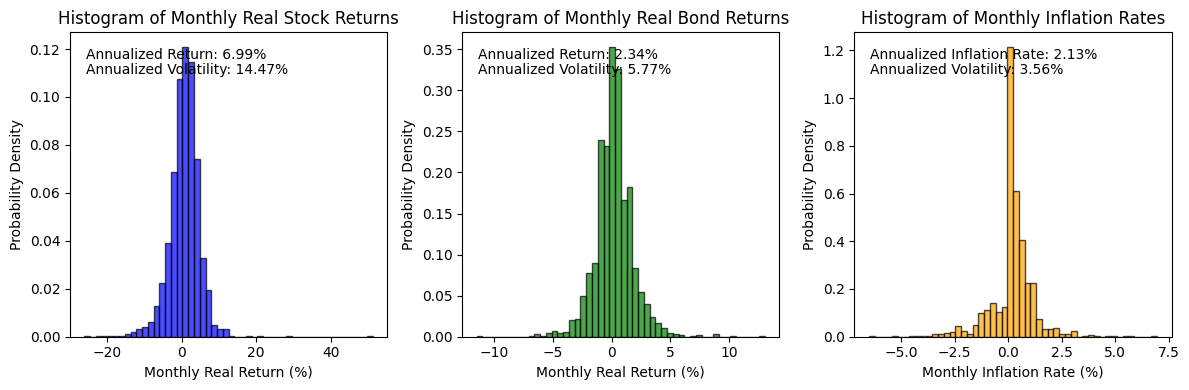


 Crazy outliers

         Date  Real Stock Return
704   1929.10          -0.261909
729   1931.11          -0.169881
733   1932.03          -0.226760
737   1932.07           0.513473
746   1933.04           0.293179
747   1933.05           0.175874
808   1938.06           0.204865
1651  2008.09          -0.200805
1788  2020.02          -0.191403


In [1]:
#@title # Code block for downloading and preparing the data + sanity-checks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data (assuming it has been downloaded from Shiller's data)
url = "https://www.dropbox.com/scl/fi/98a5ppoa3d0qhp3rui31m/ShillerSP500.csv?rlkey=zsgql64k7h6mcpmr6b65njmzs&st=11ivsbec&dl=1"
df = pd.read_csv(url)


# Calculate monthly inflation rate
df['Inflation Rate'] = df['CPI'].pct_change()

# Convert trailing 12-month dividend to a monthly dividend
df['Monthly Dividend'] = df['D'] / 12

# Calculate real stock return using inflation-adjusted prices and dividends
# df['Stock Return'] = ((df['P'].shift(-1) / df['P']) * (1 + df['Monthly Dividend'] / df['P'])) - 1
df['Stock Return'] = (df['P'].shift(-1) + df['Monthly Dividend']) / df['P'] - 1
df['Real Stock Return'] = ((1 + df['Stock Return']) /
                           (1 + df['Inflation Rate'])) - 1

# Calculate real bond returns
duration = 7  # Assume a duration of 7 years for bond fund
df['Delta Yield'] = df['GS10'].diff()
df['Bond Return'] = (df['GS10'] / 12 / 100) - duration * (df['Delta Yield'] / 100)
df['Real Bond Return'] = ((1 + df['Bond Return']) / (1 + df['Inflation Rate'])) - 1

# Drop rows with missing values after calculating real returns
df = df.dropna().reset_index(drop=True)


# Calculate the annualized inflation-adjusted return and volatility for stocks
N_stock = len(df['Real Stock Return'])
# Cumulative real return over the entire period
cumulative_stock_return = (1 + df['Real Stock Return']).prod()
# Annualize and convert to percentage
annualized_real_stock_return = (cumulative_stock_return ** (12 / N_stock) - 1) * 100
annualized_real_stock_volatility = df['Real Stock Return'].std() * np.sqrt(12) * 100

# Similarly for bonds
N_bond = len(df['Real Bond Return'])
cumulative_bond_return = (1 + df['Real Bond Return']).prod()
annualized_real_bond_return = (cumulative_bond_return ** (12 / N_bond) - 1) * 100
annualized_real_bond_volatility = df['Real Bond Return'].std() * np.sqrt(12) * 100

# Similarly for inflation rate
N_inflation = len(df['Inflation Rate'].dropna())
cumulative_inflation = (1 + df['Inflation Rate'].dropna()).prod()
annualized_inflation_rate = (cumulative_inflation ** (12 / N_inflation) - 1) * 100
annualized_inflation_volatility = df['Inflation Rate'].dropna().std() * np.sqrt(12) * 100

# Plot histograms of the monthly real stock, bond returns, and inflation
plt.figure(figsize=(12, 4))

# Histogram for real stock returns (converted to percentages)
plt.subplot(1, 3, 1)
plt.hist(df['Real Stock Return'] * 100, bins=50, color='blue',
         alpha=0.7, edgecolor='black', density=True)
plt.title('Histogram of Monthly Real Stock Returns')
plt.xlabel('Monthly Real Return (%)')
plt.ylabel('Probability Density')
plt.text(0.05, 0.95,
         f'Annualized Return: {annualized_real_stock_return:.2f}%',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90,
         f'Annualized Volatility: {annualized_real_stock_volatility:.2f}%',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Histogram for real bond returns (converted to percentages)
plt.subplot(1, 3, 2)
plt.hist(df['Real Bond Return'] * 100, bins=50, color='green',
         alpha=0.7, edgecolor='black', density=True)
plt.title('Histogram of Monthly Real Bond Returns')
plt.xlabel('Monthly Real Return (%)')
plt.ylabel('Probability Density')
plt.text(0.05, 0.95,
         f'Annualized Return: {annualized_real_bond_return:.2f}%',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90,
         f'Annualized Volatility: {annualized_real_bond_volatility:.2f}%',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Histogram for monthly inflation rates (converted to percentages)
plt.subplot(1, 3, 3)
plt.hist(df['Inflation Rate'].dropna() * 100, bins=50, color='orange',
         alpha=0.7, edgecolor='black', density=True)
plt.title('Histogram of Monthly Inflation Rates')
plt.xlabel('Monthly Inflation Rate (%)')
plt.ylabel('Probability Density')
plt.text(0.05, 0.95,
         f'Annualized Inflation Rate: {annualized_inflation_rate:.2f}%',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90,
         f'Annualized Volatility: {annualized_inflation_volatility:.2f}%',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Identify months where the stock return is greater than 15% or less than -15%
outliers = df[(df['Real Stock Return'] > 0.15) | (df['Stock Return'] < -0.15)]

# Display the outlier months and their returns
print(f'\n Crazy outliers\n ==============\n')
print(outliers[['Date', 'Real Stock Return']])


# The core of the Monte Carlo simulation using block bootstrap draws from historical data

In [2]:
#@title Function Definitions

def block_bootstrap(df, block_size, num_blocks):
    """
    Perform block bootstrap resampling on a DataFrame with historical returns.

    Parameters:
        df (DataFrame): DataFrame with 'Real Stock Return', 'Real Bond Return'.
        block_size (int): The number of consecutive months in each block.
        num_blocks (int): The number of blocks to sample.

    Returns:
        np.ndarray: Array of resampled stock and bond returns.
    """
    combined_returns = []
    n = len(df)

    for _ in range(num_blocks):
        # Randomly choose a starting index for the block
        start_idx = np.random.randint(0, n - block_size + 1)
        block = df.iloc[
            start_idx:start_idx + block_size][
                ['Real Stock Return', 'Real Bond Return']].values
        combined_returns.append(block)

    # Concatenate the sampled blocks
    combined_returns = np.concatenate(combined_returns, axis=0)
    return combined_returns


def simulate_portfolio(df, initial_value=1e6, years=30, stock_weight=0.70,
                      rebalance_frequency=3, transaction_cost_rate=0.002,
                      fixed_transaction_cost=50, withdrawal_rate=0.045,
                      block_size=12, num_simulations=1000):
    # Convert years to months
    months = years * 12

    results = []
    depletion_count = 0

    # Run multiple simulations
    for _ in range(num_simulations):
        # Resample blocks of returns using block bootstrapping
        num_blocks = int(np.ceil(months / block_size))
        resampled_returns = block_bootstrap(df, block_size, num_blocks)
        # Trim to exact number of months just in case
        resampled_returns = resampled_returns[:months]

        # Extract resampled stock and bond returns
        resampled_stock_returns = resampled_returns[:, 0]
        resampled_bond_returns = resampled_returns[:, 1]

        # Initialize portfolio values
        stock_value = initial_value * stock_weight
        bond_value = initial_value * (1 - stock_weight)

        # Track the portfolio value over time
        portfolio_values = np.zeros(months)

        # Monthly withdrawal in real terms
        monthly_withdrawal = initial_value * withdrawal_rate / 12

        # Flag to check if the portfolio runs out of money
        portfolio_depleted = False

        # Simulate month by month using the resampled returns
        for month in range(months):
            # Apply returns first
            stock_return = resampled_stock_returns[month]
            bond_return = resampled_bond_returns[month]

            stock_value *= (1 + stock_return)
            bond_value *= (1 + bond_return)

            # Calculate total portfolio value
            total_value = stock_value + bond_value

            # Check for portfolio depletion after returns
            if total_value <= 0:
                portfolio_depleted = True
                portfolio_values[month:] = 0
                break

            # Apply the monthly withdrawal proportionally
            stock_proportion = stock_value / total_value
            bond_proportion = bond_value / total_value

            stock_value -= monthly_withdrawal * stock_proportion
            bond_value -= monthly_withdrawal * bond_proportion

            # Ensure asset values don't go negative
            stock_value = max(stock_value, 0)
            bond_value = max(bond_value, 0)

            # Update total portfolio value after withdrawal
            total_value = stock_value + bond_value

            # Check for portfolio depletion after withdrawal
            if total_value <= 0:
                portfolio_depleted = True
                portfolio_values[month:] = 0
                break

            # Record the portfolio value
            portfolio_values[month] = total_value

            # Rebalance the portfolio if required
            if total_value > 0 and (month + 1) % rebalance_frequency == 0:
                # Rebalance to target weights
                target_stock_value = total_value * stock_weight
                target_bond_value = total_value * (1 - stock_weight)

                # Calculate the total amount that needs to be rebalanced
                stock_rebalance_amount = abs(stock_value - target_stock_value)
                bond_rebalance_amount = abs(bond_value - target_bond_value)
                rebalance_amount = (stock_rebalance_amount +
                                    bond_rebalance_amount)

                # Apply transaction costs
                transaction_cost = (transaction_cost_rate * rebalance_amount +
                                    fixed_transaction_cost)

                # Deduct transaction cost from the total portfolio value
                total_value -= transaction_cost

                # Check if transaction costs depleted the portfolio
                if total_value <= 0:
                    portfolio_depleted = True
                    portfolio_values[month:] = 0
                    break

                # Update stock and bond values after transaction cost
                stock_value = total_value * stock_weight
                bond_value = total_value * (1 - stock_weight)

        # Track if the portfolio ran out of money
        if portfolio_depleted:
            depletion_count += 1
        else:
            # Ensure the last month's portfolio value is recorded
            portfolio_values[month] = total_value

        # Append the simulation results
        results.append(portfolio_values)

    # Convert results to a numpy array for easier analysis
    results_array = np.array(results)

    return results_array, depletion_count


## Description of function parameters
We'll simulate the portfolio growth over time using the specified withdrawal rates (inflation-adjusted), rebalancing, and transaction costs. To do the Monte Carlo draws, we sample from historical returns, but in blocks (i.e., capturing some of the temporal autocorrelation, and also the correlation between asset classes).

## Inputs

- **`df` (DataFrame)**: This parameter represents the historical data, containing monthly real stock returns, real bond returns, and inflation rates. It is used for resampling and calculating portfolio returns in the simulation.

- **`initial_value` (float)**: The starting value of the portfolio, specified in dollars. This represents the initial investment amount, with a default of $1,000,000. It serves as the baseline for calculating withdrawals and tracking portfolio growth.

- **`years` (int)**: The duration of the simulation, specified in years. It determines the total length of time over which the portfolio is simulated, with the default set to 30 years. The duration is converted to months internally (`years * 12`) for monthly calculations.

- **`stock_weight` (float)**: The target weight for stocks in the portfolio, expressed as a proportion of the total portfolio value. For example, a value of 0.70 means 70% of the portfolio is allocated to stocks, while the remaining 30% is allocated to bonds. The default value is 0.70.

- **`rebalance_frequency` (int)**: Specifies how often the portfolio should be rebalanced to maintain the target stock and bond allocation, measured in months. For instance, a value of 3 means the portfolio is rebalanced every three months. This helps keep the asset allocation close to the intended target over time.

- **`transaction_cost_rate` (float)**: Represents the percentage of the rebalanced amount that is incurred as a transaction cost, simulating the cost of trading. For example, a value of 0.002 means a 0.2% fee is applied to the amount being rebalanced. The default value is 0.002 (0.2%).

- **`fixed_transaction_cost` (float)**: A fixed dollar amount charged per rebalancing event, in addition to the percentage-based transaction cost. This simulates flat fees that brokers may charge for transactions. The default value is $50.

- **`withdrawal_rate` (float)**: The initial annual withdrawal rate, expressed as a percentage of the portfolio's value. This rate determines the amount withdrawn each year in real terms. For example, a value of 0.045 indicates a 4.5% annual withdrawal rate, corresponding to a monthly withdrawal of `(initial_value * 4.5%) / 12`. The default value is 0.045 (4.5%).

- **`block_size` (int)**: The number of consecutive months in each block used for block bootstrapping. This parameter helps preserve patterns of autocorrelation in the returns by resampling chunks of consecutive data instead of individual months. The default value is 12 months.

- **`num_simulations` (int)**: The number of Monte Carlo simulations to run. Each simulation represents a different possible path for the portfolio's growth, based on resampling the historical data. More simulations help improve the robustness of the results by exploring a wider range of potential outcomes. The default is set to 1,000 simulations.



# Set parameters, run simulations, and show results

This is the part where we can set/alter inputs to the simulation.

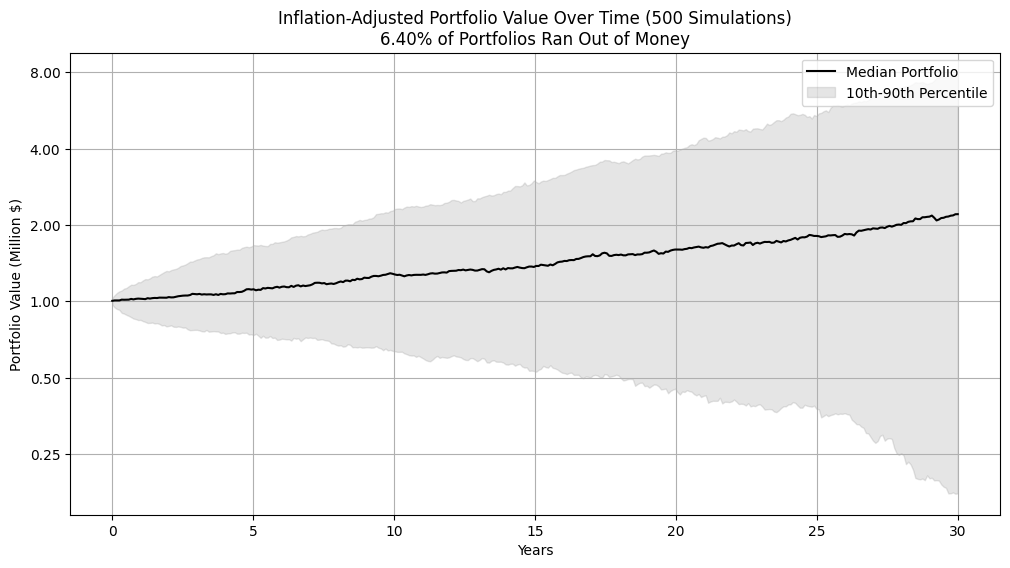

In [3]:
# Set the parameters for the simulation
simulation_params = {
    'initial_value': 1e6,            # $1 million starting portfolio
    'years': 30,                     # 30-year simulation
    'stock_weight': 0.7,            # e.g., 0.7 for 70% stocks, 30% bonds
    'rebalance_frequency': 3,        # Rebalance every N months
    'transaction_cost_rate': 0.002,  # Proportion of the rebalanced amount
    'fixed_transaction_cost': 0,    # Fixed cost ($) per rebalancing
    'withdrawal_rate': 0.04,        # Initial annual withdrawal rate (real)
    'block_size': 12,                # Block size of in months
    'num_simulations': 500          # Number of Monte Carlo simulations
}

# Run the inflation-adjusted Monte Carlo simulations with block bootstrapping
results_array, depletion_count = simulate_portfolio(df, **simulation_params)


# Calculate percentiles for the results
median_portfolio = np.percentile(results_array, 50, axis=0)
percentile_10 = np.percentile(results_array, 10, axis=0)
percentile_90 = np.percentile(results_array, 90, axis=0)
depletion_percentage = (depletion_count /
                        simulation_params['num_simulations']) * 100

# Plot the results
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Number of years for the simulation
years = simulation_params['years']
months = years * 12

# Convert the results from dollars to millions of dollars
results_in_millions = results_array / 1e6

# Calculate percentiles for plotting
median_portfolio = np.percentile(results_in_millions, 50, axis=0)
percentile_10 = np.percentile(results_in_millions, 10, axis=0)
percentile_90 = np.percentile(results_in_millions, 90, axis=0)

depletion_percentage = (depletion_count /
                        simulation_params['num_simulations']) * 100

# Generate the x-axis values in years
x_values_years = np.linspace(0, years, months)

# Plot the results in log scale
plt.figure(figsize=(12, 6))
plt.plot(x_values_years, median_portfolio, label='Median Portfolio',
         color='black')
plt.fill_between(x_values_years, percentile_10, percentile_90, alpha=0.2,
                 label='10th-90th Percentile', color='grey')
plt.title(f'Inflation-Adjusted Portfolio Value Over Time '
          f'({simulation_params["num_simulations"]} Simulations)\n'
          f'{depletion_percentage:.2f}% of Portfolios Ran Out of Money')
plt.xlabel('Years')
plt.ylabel('Portfolio Value (Million $)')
plt.yscale('log')  # Set y-axis to log scale

# Customize the ticks using LogLocator for better control over tick appearance
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(ticker.LogLocator(base=2.0, numticks=10))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=2.0, subs='auto', numticks=10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  # Ensure tick labels are integers

plt.grid(True, which='both', axis='both')  # Grid for both major and minor ticks on y-axis
plt.legend()
plt.show()